# PS reconstruction, Gaussian beam, t scan study

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan, run_t_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.visualization import plot_3d_scan_data
from phase_space_reconstruction.train import train_3d_scan, train_3d_scan_parallel_gpus

from bmadx.distgen_utils import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

## Create synthetic ground truth beam

In [2]:
# create synthetic ground truth beam from base and transform yaml files
yaml_dir = os.path.join('data', 'yaml_files')
save_dir = os.path.join('data', 'gaussian_beam', 't_scan')
p0c = 43.36e6 # reference momentum in eV/c
gt_beam = create_beam(
    base_yaml = os.path.join(yaml_dir, 'base.yaml'),
    transforms_yaml = os.path.join(yaml_dir, 'transforms-linear-no-z-E-corr.yaml'), 
    p0c = p0c,
    n_particle = 100_000,
    save_as = os.path.join(save_dir, 'gaussian_beam.pt')
)

ground truth distribution saved at data/gaussian_beam/t_scan/gaussian_beam.pt


0.0092251655


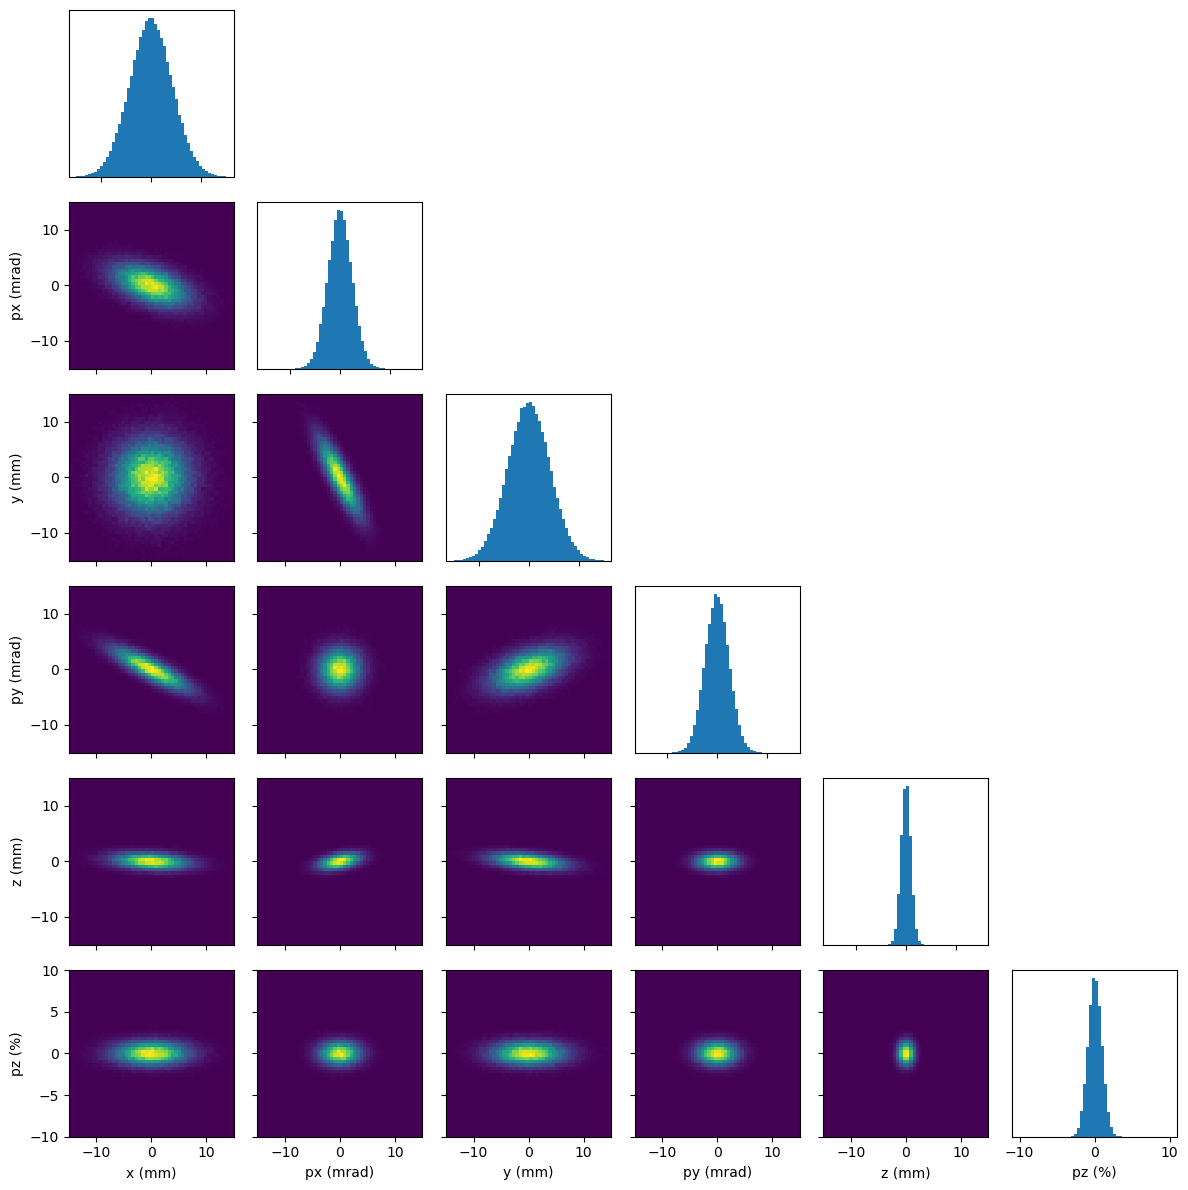

In [3]:
#plot gt beam
import numpy as np
lims = np.array([[-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-10e-2, 10e-2]]) 
fig, ax = plot_projections(
    gt_beam.numpy_particles(),
    custom_lims = lims,
    background = 0
)
print(np.std(gt_beam.numpy_particles().pz))
plt.show()

## Define diagnostics lattice parameters

In [4]:
# triplet params obtained from triplet-opt.ipynb
k1 =    10.986991
k2 =   -24.674763
k3 =    26.907939

In [5]:
# diagnostic beamline:
lattice = quadlet_tdc_bend(p0c=p0c, dipole_on=False)
lattice.elements[0].K1.data = torch.tensor(k1)
lattice.elements[2].K1.data = torch.tensor(k2)
lattice.elements[4].K1.data = torch.tensor(k3)

# Scan over quad strength, tdc on/off and dipole on/off
scan_ids = [6, 8, 10] 
n_ks = 5
ks = torch.linspace(-10, 10, n_ks) # quad ks
vs = torch.tensor([0, 1e7]) # TDC off/on
gs = torch.tensor([2.22e-16, 20.0*PI/180.0/0.365]) # dipole off/on
train_params = torch.stack(torch.meshgrid(ks, vs, gs, indexing='ij'))
print(train_params.shape)
print(train_params.unsqueeze(-1).shape)

# create diagnostic screen: 
bins = torch.linspace(-50, 50, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

torch.Size([3, 5, 2, 2])
torch.Size([3, 5, 2, 2, 1])


## Complete 3D scan training data

In [6]:
# generate and save train and test datasets
train_dset_3d_scan = run_3d_scan(
    gt_beam, 
    lattice,
    screen, 
    ks, vs, gs,
    ids = scan_ids,
    save_as = os.path.join(save_dir, '3d_scan_train.dset')
    )

print(train_dset_3d_scan.params.shape)
print(train_dset_3d_scan.images.shape)

dataset saved as 'data/gaussian_beam/t_scan/3d_scan_train.dset'
torch.Size([20, 3, 1])
torch.Size([20, 1, 200, 200])


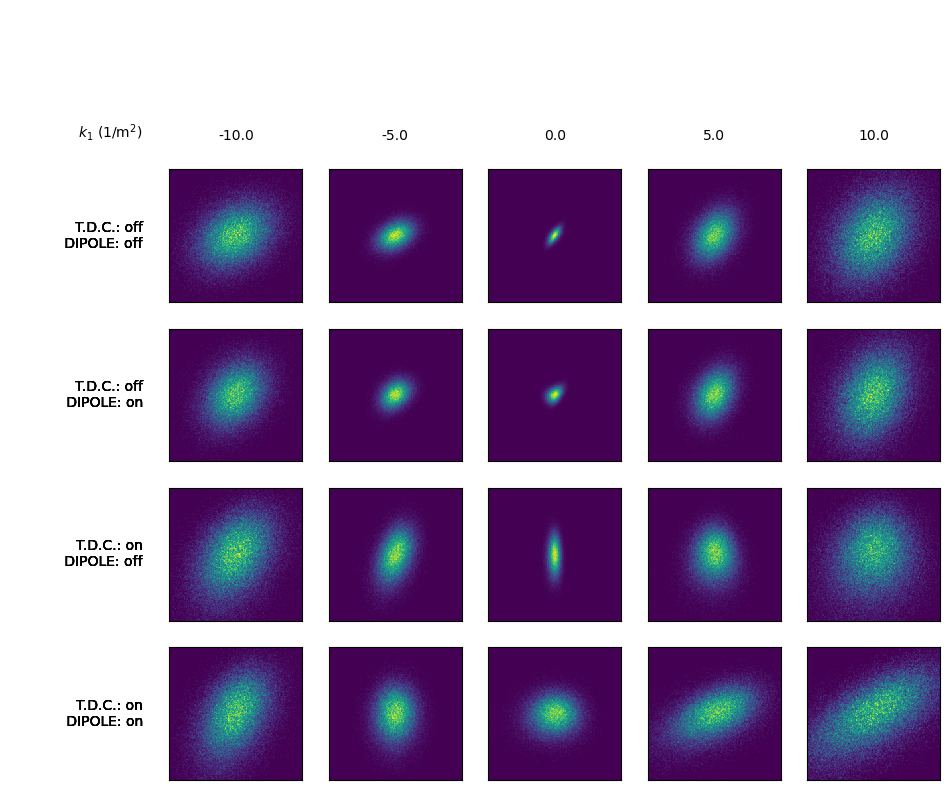

In [7]:
fig, ax = plot_3d_scan_data(train_dset_3d_scan)
plt.show()

In [21]:
%%time

# training with 4 gpus
pred_beam_3d_scan_100_000, model = train_3d_scan(
    train_dset_3d_scan, 
    lattice, 
    p0c, 
    screen,
    ids = scan_ids,
    n_epochs = 3_000, 
    n_particles = 100_000, 
    device = 'cuda:0',
    lambda_=1e14
    )

Using device: cuda:0
0 tensor(3.2225e+09, device='cuda:0', grad_fn=<MulBackward0>)
100 tensor(5.3913e+08, device='cuda:0', grad_fn=<MulBackward0>)
200 tensor(5.8132e+08, device='cuda:0', grad_fn=<MulBackward0>)
300 tensor(6.5212e+08, device='cuda:0', grad_fn=<MulBackward0>)
400 tensor(5.4064e+08, device='cuda:0', grad_fn=<MulBackward0>)
500 tensor(5.9488e+08, device='cuda:0', grad_fn=<MulBackward0>)
600 tensor(5.9772e+08, device='cuda:0', grad_fn=<MulBackward0>)
700 tensor(6.3096e+08, device='cuda:0', grad_fn=<MulBackward0>)
800 tensor(5.6443e+08, device='cuda:0', grad_fn=<MulBackward0>)
900 tensor(5.8712e+08, device='cuda:0', grad_fn=<MulBackward0>)
1000 tensor(6.1885e+08, device='cuda:0', grad_fn=<MulBackward0>)
1100 tensor(6.3633e+08, device='cuda:0', grad_fn=<MulBackward0>)
1200 tensor(5.9285e+08, device='cuda:0', grad_fn=<MulBackward0>)
1300 tensor(5.7362e+08, device='cuda:0', grad_fn=<MulBackward0>)
1400 tensor(6.2143e+08, device='cuda:0', grad_fn=<MulBackward0>)
1500 tensor(6.41

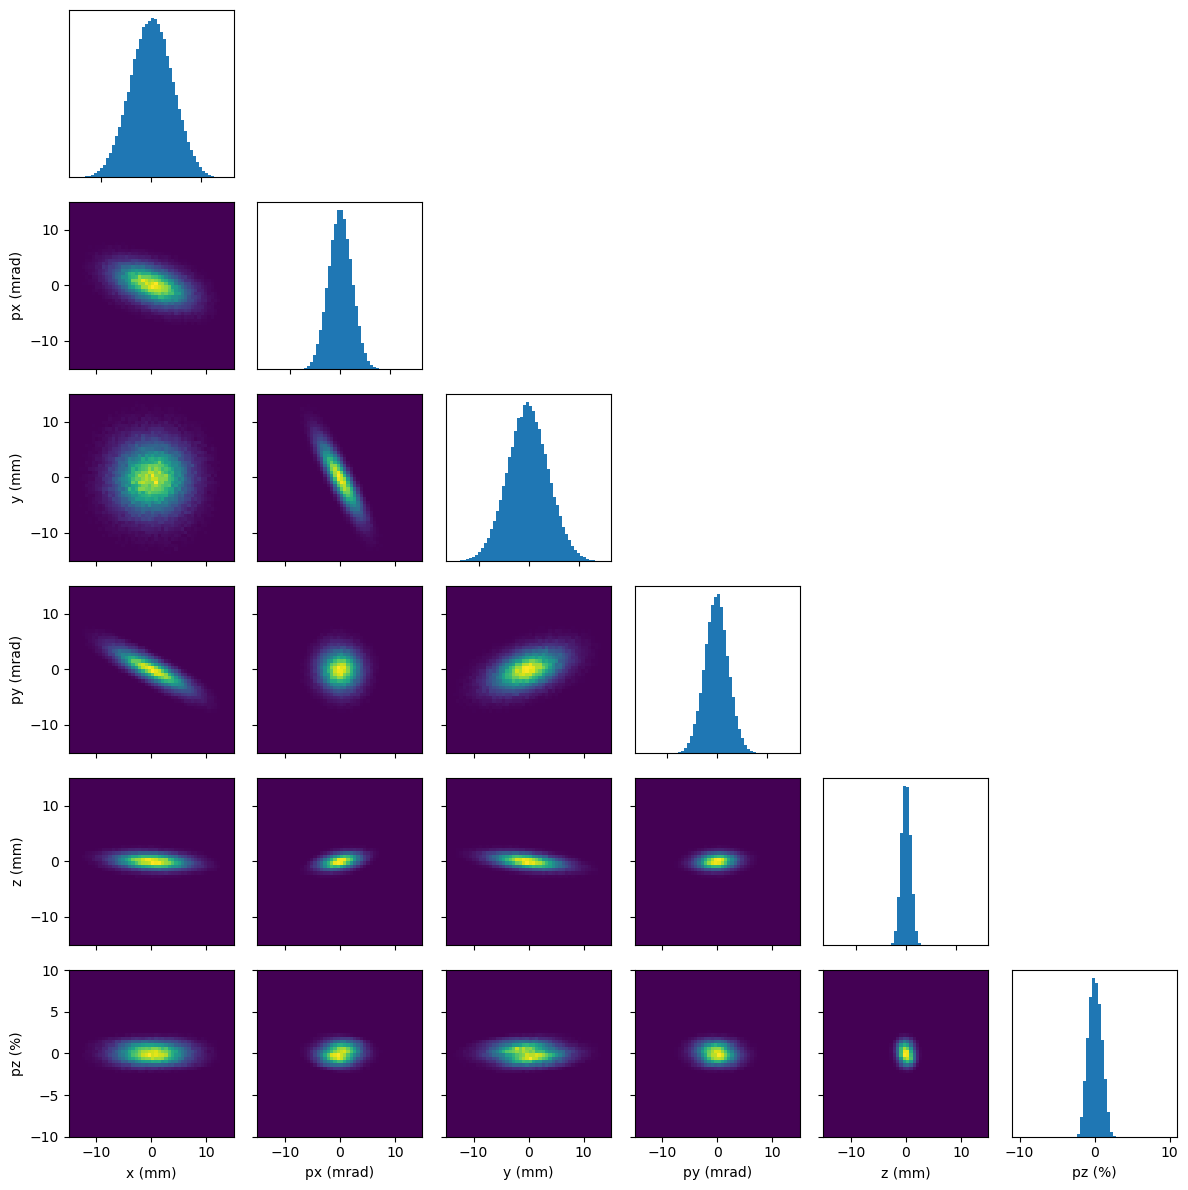

In [9]:
# reconstructed beam projections:
fig, ax = plot_projections(
    pred_beam_3d_scan_100_000.numpy_particles(),
    custom_lims = lims
)
plt.show()

(<Figure size 3600x3600 with 36 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='px (mrad)'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='y (mm)'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: ylabel='py (mrad)'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='z (mm)'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: xlabel='x (mm)', ylabel='pz (mrad)'>,
         <Axes: xlabel='px (mrad)'>, <Axes: xlabel='y (mm)'>,
         <Axes: xlabel='py (mrad)'>, <Axes: xlabel='z (mm)'>,
         <Axes: xlabel='pz (mrad)'>]], dtype=object))

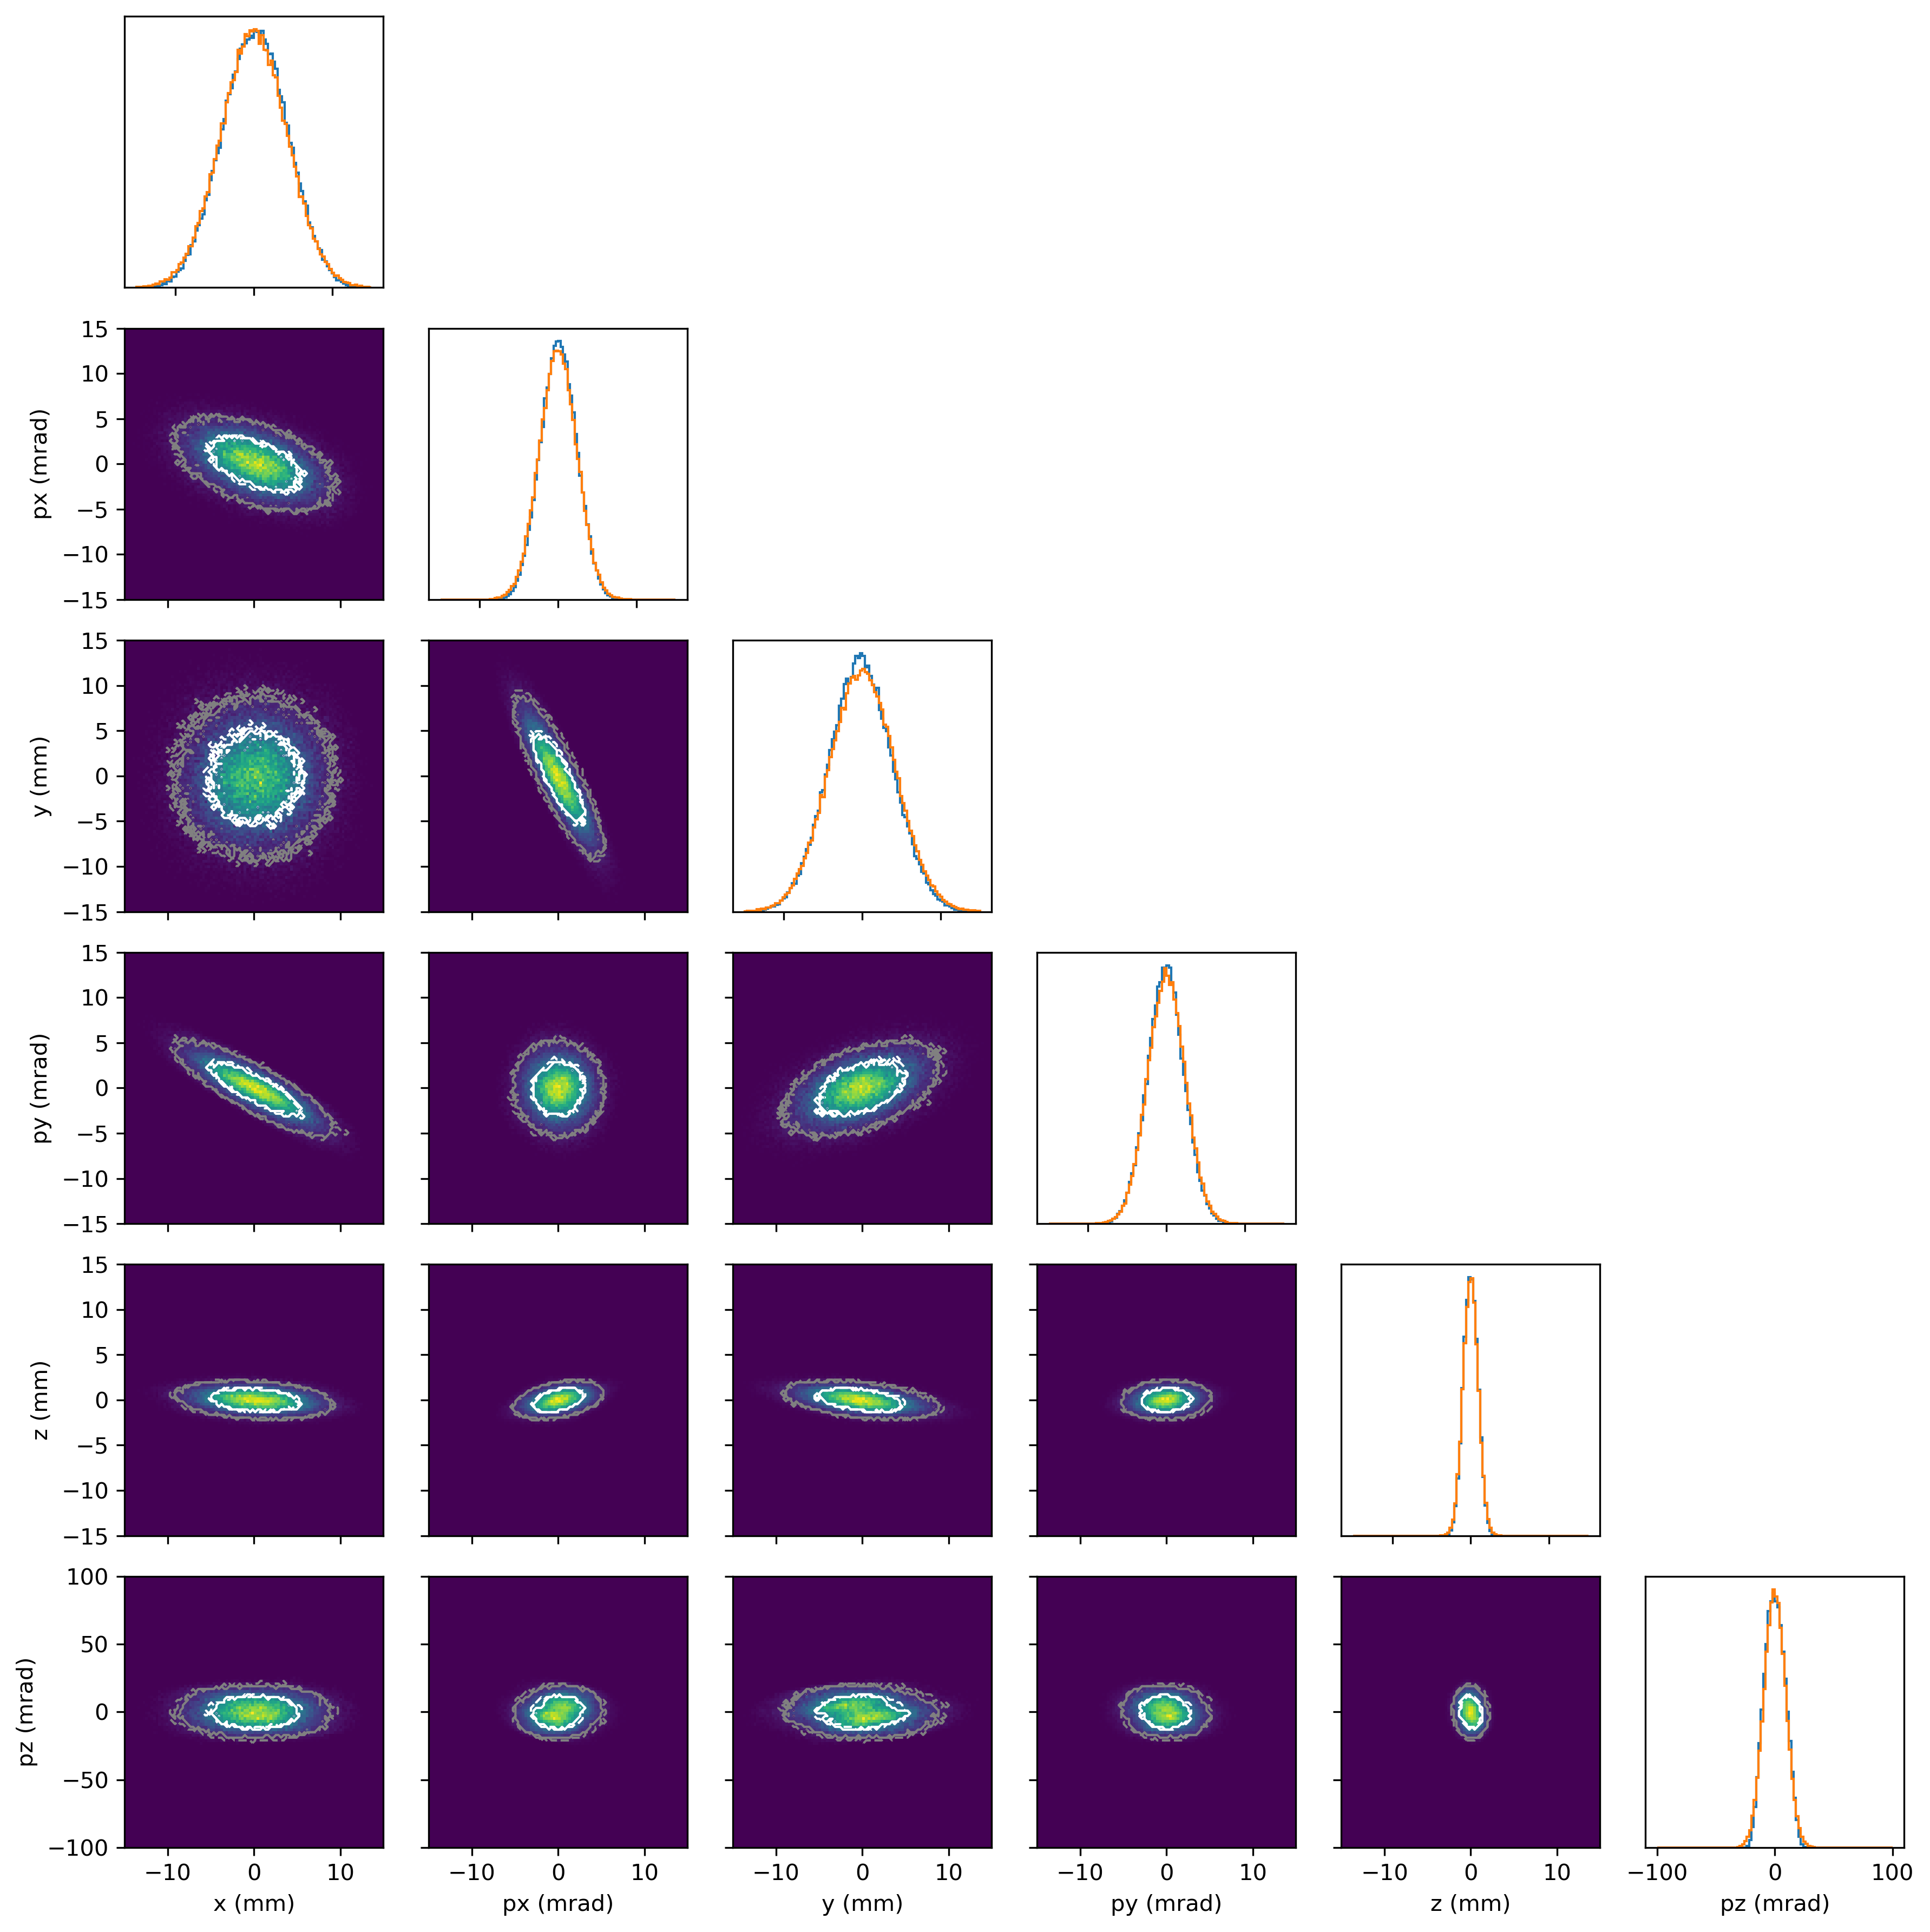

In [19]:
from stats import plot_projections_with_contours
plot_projections_with_contours(
    pred_beam_3d_scan_100_000,
    gt_beam,
    bins=100,
    contour_percentiles = [50, 90],
    custom_lims=lims,
    contour_smoothing_r=0.01,
    contour_smoothing_gt=0.01,
)

In [10]:
torch.save(
    pred_beam_3d_scan_100_000,
    os.path.join(save_dir, '3D_scan_100_000.pt')
)

In [11]:
torch.cuda.empty_cache()

## 'T' scan training data

torch.Size([8, 3, 1])
tensor([[-1.0000e+01,  0.0000e+00,  2.2200e-16],
        [-5.0000e+00,  0.0000e+00,  2.2200e-16],
        [ 0.0000e+00,  0.0000e+00,  2.2200e-16],
        [ 5.0000e+00,  0.0000e+00,  2.2200e-16],
        [ 1.0000e+01,  0.0000e+00,  2.2200e-16],
        [ 0.0000e+00,  0.0000e+00,  9.5634e-01],
        [ 0.0000e+00,  1.0000e+07,  2.2200e-16],
        [ 0.0000e+00,  1.0000e+07,  9.5634e-01]])
dataset saved as 'data/gaussian_beam/t_scan/t_scan_train.dset'
torch.Size([8, 3, 1])
torch.Size([8, 1, 200, 200])


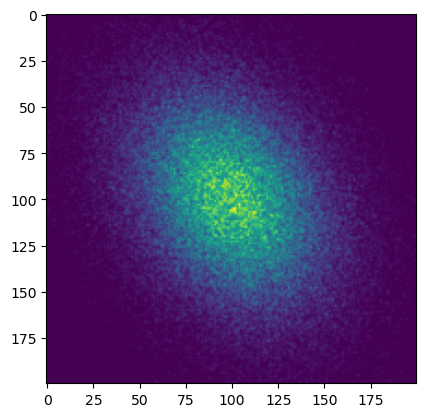

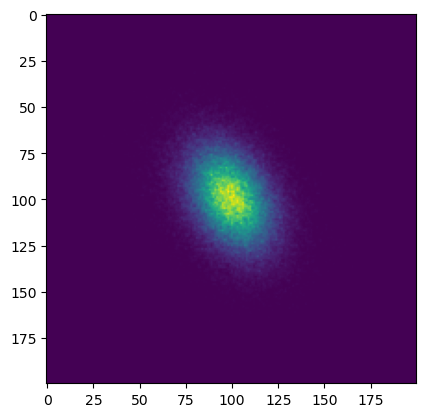

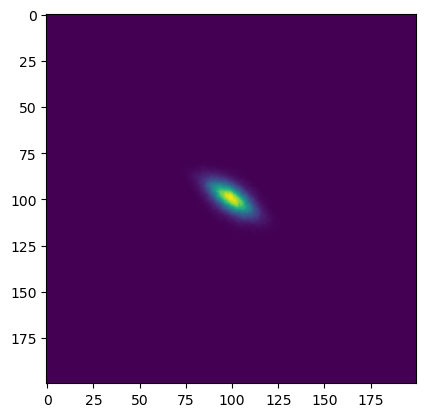

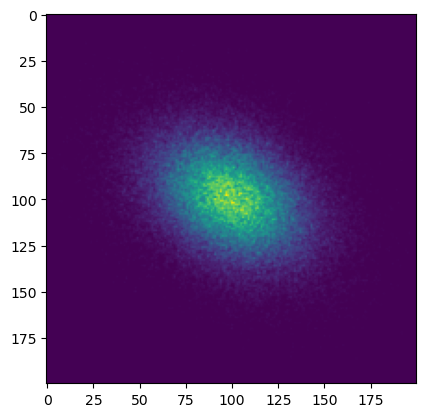

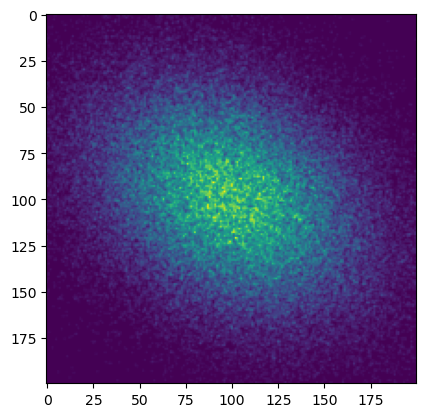

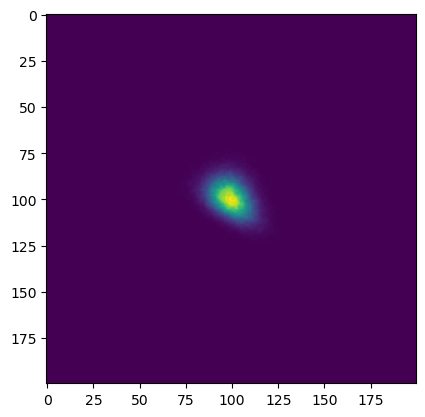

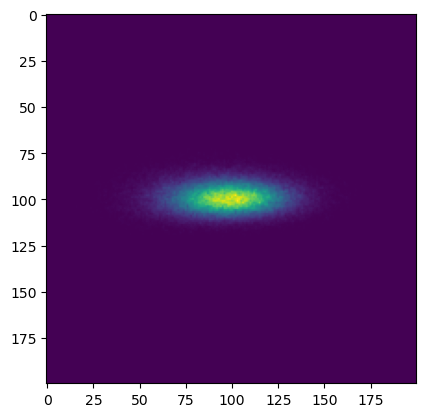

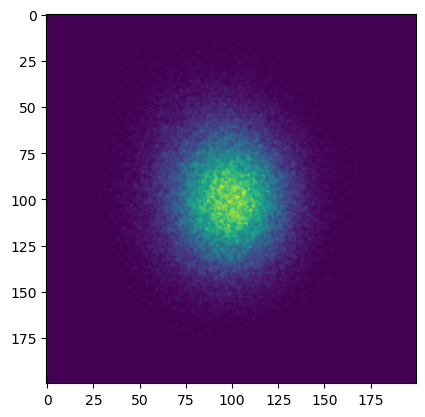

In [12]:
# generate and save train and test datasets
train_dset_t_scan = run_t_scan(
    gt_beam, 
    lattice,
    screen, 
    ks, vs, gs,
    ids = scan_ids,
    save_as = os.path.join(save_dir, 't_scan_train.dset')
    )

print(train_dset_t_scan.params.shape)
print(train_dset_t_scan.images.shape)

for ele in train_dset_t_scan.images:
    plt.figure()
    plt.imshow(ele.squeeze())

In [13]:
%%time

# training
pred_beam_t_scan_100_000,model = train_3d_scan(
    train_dset_t_scan, 
    lattice, 
    p0c, 
    screen,
    ids = scan_ids,
    n_epochs = 3_000, 
    n_particles = 100_000, 
    device = 'cuda:0'
    )

Using device: cuda:0
0 tensor(4024812.2500, device='cuda:0', grad_fn=<MulBackward0>)
100 tensor(467079.1875, device='cuda:0', grad_fn=<MulBackward0>)
200 tensor(461543.4375, device='cuda:0', grad_fn=<MulBackward0>)
300 tensor(476828.8125, device='cuda:0', grad_fn=<MulBackward0>)
400 tensor(470202.1250, device='cuda:0', grad_fn=<MulBackward0>)
500 tensor(466591.8125, device='cuda:0', grad_fn=<MulBackward0>)
600 tensor(469248.1562, device='cuda:0', grad_fn=<MulBackward0>)
700 tensor(461610.2500, device='cuda:0', grad_fn=<MulBackward0>)
800 tensor(461338.6250, device='cuda:0', grad_fn=<MulBackward0>)
900 tensor(452230.3125, device='cuda:0', grad_fn=<MulBackward0>)
1000 tensor(465264.8438, device='cuda:0', grad_fn=<MulBackward0>)
1100 tensor(453573.1875, device='cuda:0', grad_fn=<MulBackward0>)
1200 tensor(463674.1250, device='cuda:0', grad_fn=<MulBackward0>)
1300 tensor(462698.9688, device='cuda:0', grad_fn=<MulBackward0>)
1400 tensor(456329.8750, device='cuda:0', grad_fn=<MulBackward0>)


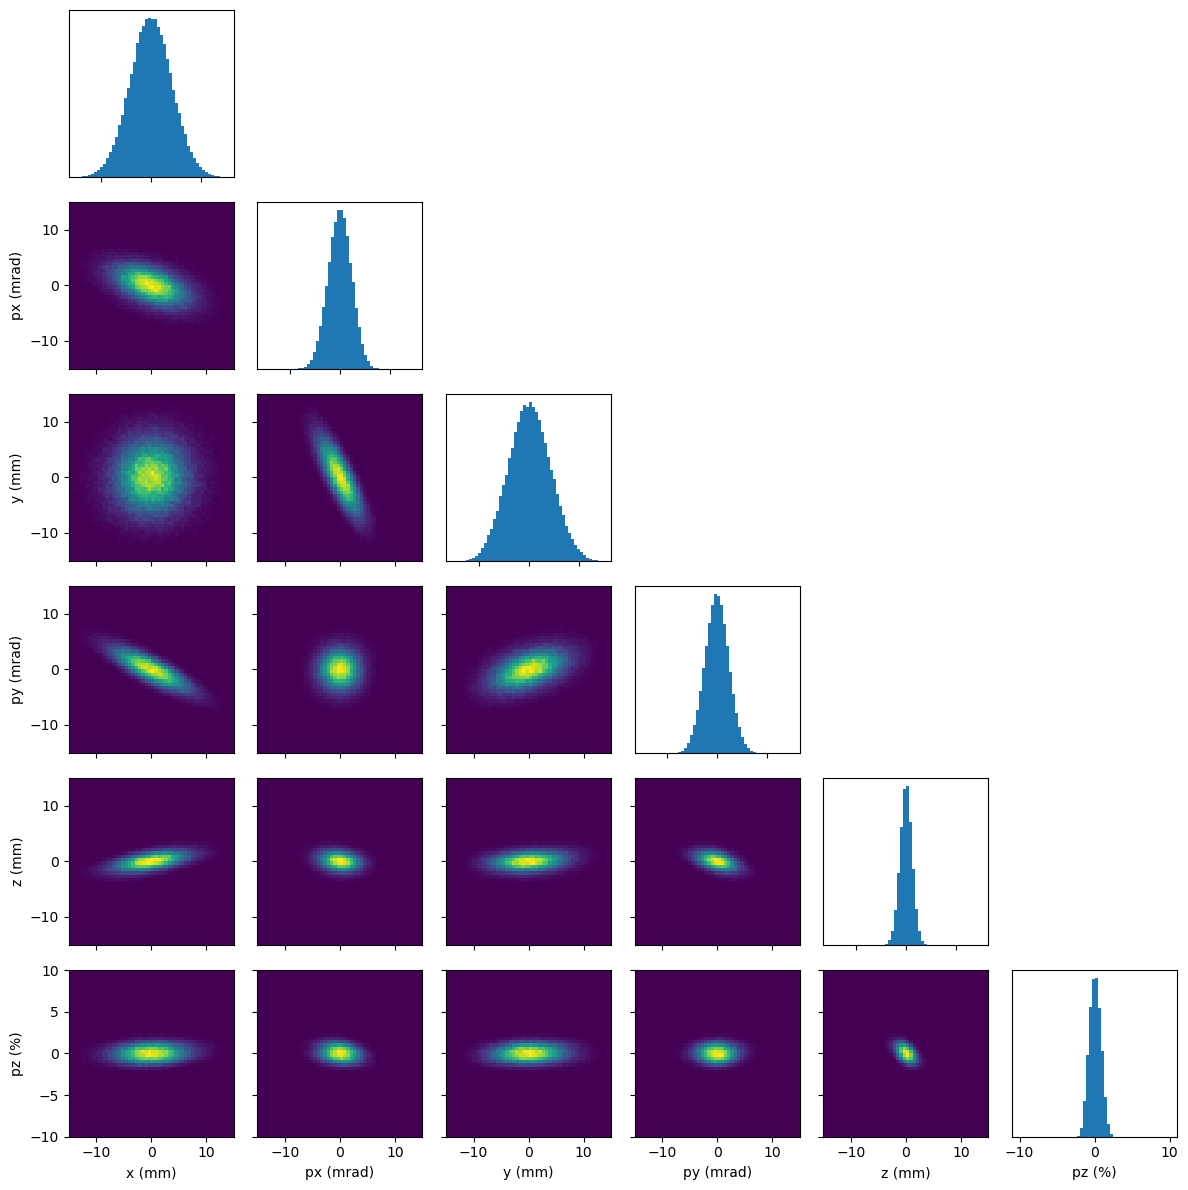

In [14]:
# reconstructed beam projections:
fig, ax = plot_projections(
    pred_beam_t_scan_100_000.numpy_particles(),
    custom_lims = lims
)
plt.show()

In [15]:
torch.cuda.empty_cache()

In [16]:
torch.save(pred_beam_t_scan_100_000,
           os.path.join(save_dir, 't_scan_100_000.pt'))

(<Figure size 3600x3600 with 36 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='px (mrad)'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='y (mm)'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: ylabel='py (mrad)'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='z (mm)'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: xlabel='x (mm)', ylabel='pz (mrad)'>,
         <Axes: xlabel='px (mrad)'>, <Axes: xlabel='y (mm)'>,
         <Axes: xlabel='py (mrad)'>, <Axes: xlabel='z (mm)'>,
         <Axes: xlabel='pz (mrad)'>]], dtype=object))

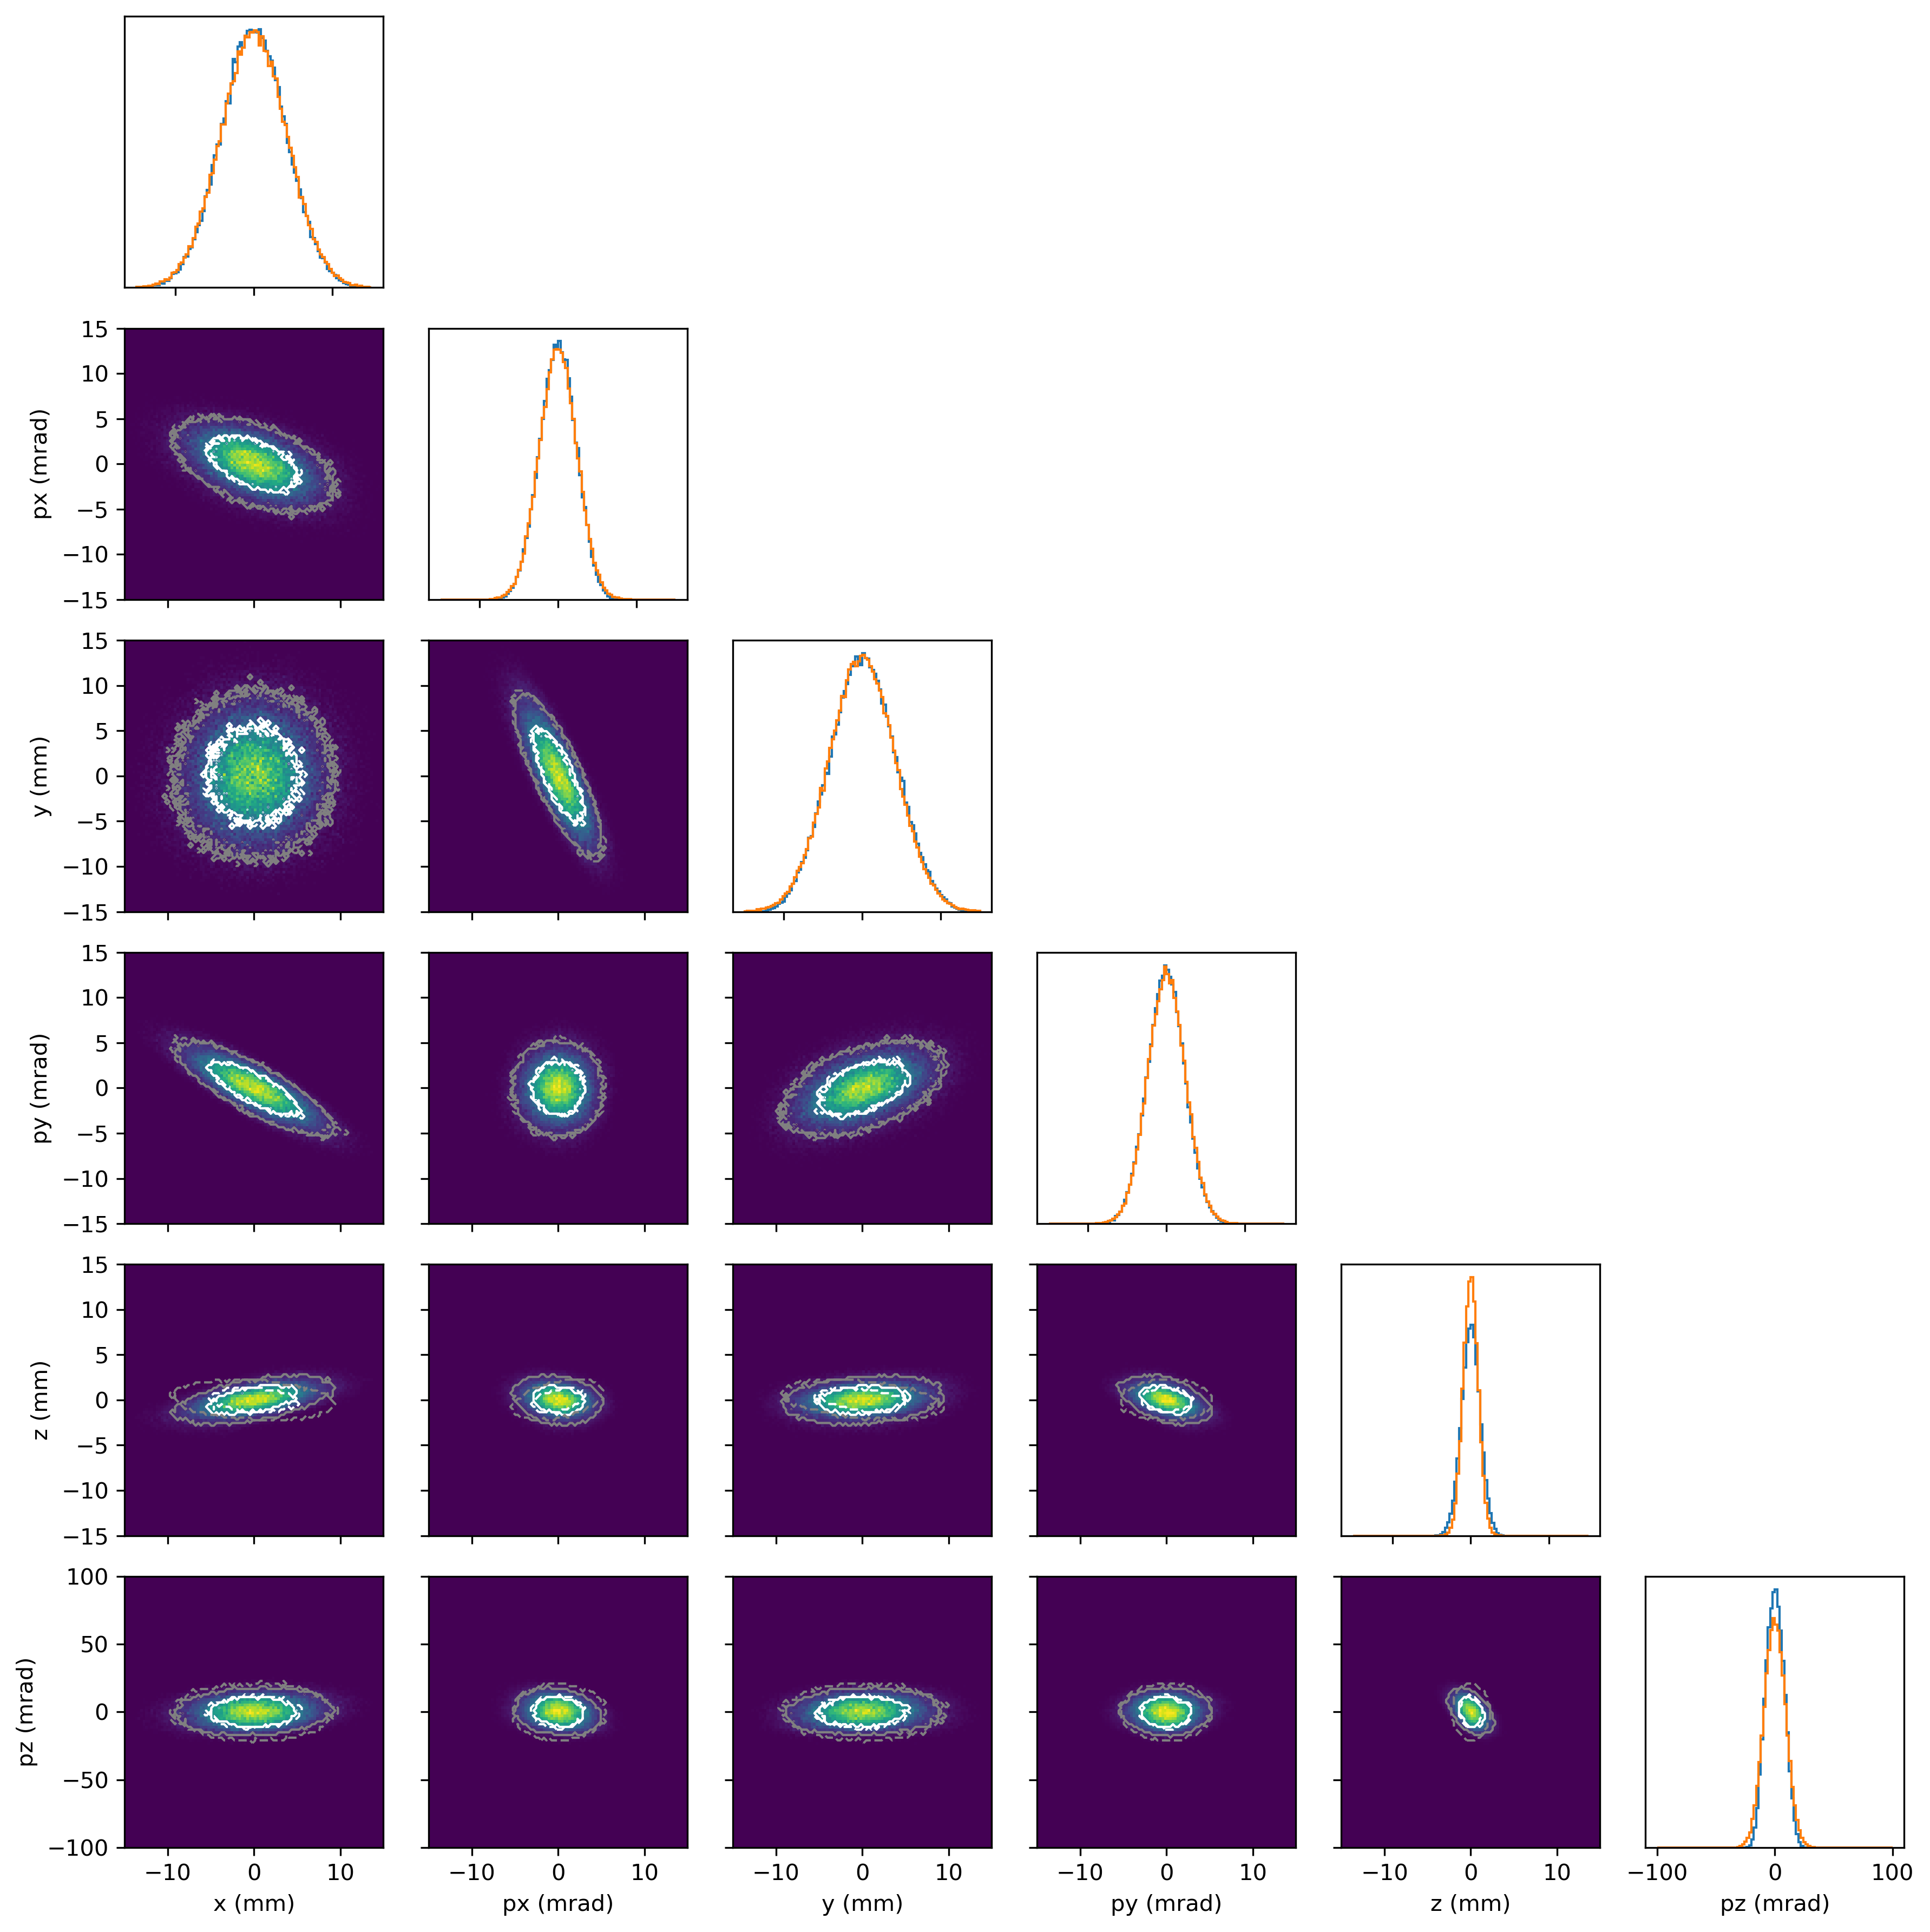

In [17]:
from stats import plot_projections_with_contours
plot_projections_with_contours(
    pred_beam_t_scan_100_000,
    gt_beam,
    bins=100,
    contour_percentiles = [50, 90],
    custom_lims=lims,
    contour_smoothing_r=0.01,
    contour_smoothing_gt=0.01,
)